# Gaining an Analytics Edge Using Federal Spending Open Data

### Blog #2 Automating the Information Gathering Process

**Premise of this Blog Series**: Publicly available “**open data**” sources and open-source technology analytics can provide information to reduce uncertainty when making critical business investment decisions.

**Purpose**: Demonstrate to **executives** how easy it is to access and analyze free, open-data sources and motivate them to expect more insight and context from their team when making crucial go/no-go **investment decisions** on bids and new offerings.

**Scope**: US Federal Contracting Market.

"#FederalSpending #Analytics #MarketAnalysis #Python #OpenData"

## The following Python code automates the manual steps described in [my first Medium.com post on this topic found here](https://medium.com/@lulstrup/gaining-an-analytics-edge-using-federal-spending-open-data-7cc69a063c68).[link text](https://)

The code below can be [found in this FREE Google Colab notebook](https://colab.research.google.com/drive/1AISewRUz3NkmAHa4pWV1KOt8hAVu1yYD?usp=sharing) where you can save a copy into your Google Drive and open the notebook and execute this code on your own. The code is executed with Shift-Enter or by selecting the > in the circle symbol on the upper left of a code cell.

If you are completely new to Python, free and low cost resources are abundant. Follow [this link](https://github.com/leifulstrup/Python_Getting_Started_Favorite_Resources/blob/master/README.md) for some of my favorite sources to get started with Python.


The customary first step in Python appplications is to import the packages.

In [ ]:
import os, glob
import pandas as pd
import requests
import bs4
import json
import time
from datetime import datetime
import zipfile

The next code is not essential but is a good way to search the [USAspending.gov API](https://api.usaspending.gov/) information as one expands the class methods for the Python API access below.

In [ ]:
def Get_API_Github_Definition(url_test_api):
    pass
    # need to use selenium to get the "here" link to github code
    return
    
#TEST
Get_API_Github_Definition("https://api.usaspending.gov/api/v2/award_spending/recipient/?fiscal_year=2016&awarding_agency_id=183")
    

def Get_API_Endpoints():

    url_root = "https://api.usaspending.gov"
    
    r = requests.get("https://api.usaspending.gov/docs/endpoints")

    #r.content

    soup = bs4.BeautifulSoup(r.content)

    results_list = []

    table = soup.find('table')
    thead = table.find('thead').find('tr')
#     for header in thead:
#         print(header)
#         # gather header titles
    for tr in table.find_all('tr'):
        elements = []
        for td in tr.find_all('td'):
            for a in td.find_all('a'):
                try:
                    elements.append(url_root + a['href'])
                    #print("...", a['href']) #, a['href'])
                except:
                    pass
                    #print(a)
            #print(td.text)
            elements.append(td.text)
            
        if elements:
            results_list.append({'url_test_api' : elements[0], 'Endpoint' : elements[1], 'Methods' : elements[2], 'Description' : elements[3]})
        #print()
    df = pd.DataFrame(results_list)
    df['Endpoint_Labels'] = df['Endpoint'].apply(lambda x: "_".join(x.split("/")[3:])[0:-1])
    return df

df_api_endpoints = Get_API_Endpoints()
df_api_endpoints

This following Python code defines a Python object class for accessing a limited number of the USAspending API features. It can easily be extended and improved.

In [ ]:
class USAspending(): 
#TODO: refactor and simplify the code (the code in several of the methods is redundant and should be streamlined) for maintainability 
#TODO: add more tests to confirm it is working correctly and reliably

    url_root = 'https://api.usaspending.gov' #!! note it is api.usaspending.gov NOT www.usaspending.gov
    api = {}
    api['parent_child'] = '/api/v2/recipient/children/' #'/DUNS'
    api['recipient_spending_category'] = '/api/v2/search/spending_by_category/recipient_duns/'
    api['recipient_overview'] = "/api/v2/recipient/duns/"
    api['autocomplete_psc'] = "/api/v2/autocomplete/funding_psc/"
    api['autocomplete_funding_agency'] = "/api/v2/autocomplete/funding_agency/"
    api['autocomplete_glossary'] = "/api/v2/autocomplete/glossary/"
    api['bulk_download_awards'] = "/api/v2/bulk_download/awards/"
    api['bulk_download_list_agencies'] = "/api/v2/bulk_download/list_agencies/"
    api['bulk_download_status'] = "/api/v2/bulk_download/status/"
    
    USER_AGENT = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:65.0) Gecko/20100101 Firefox/65.0"
    USER_AGENT = "XY" #solves 406 error on redirect of the biden mailer click link # 
    headers = {"user-agent" : USER_AGENT}

    def __init__(self,):
        pass # this __init__ can include variables set up at the creation of the object for this class, TBD
    
    def Get_URL_API(self, api_name, contents=""):
        if contents == '':
          return self.url_root + self.api[api_name]
        else:
          return self.url_root + self.api[api_name] + contents + '/'
               
    def API_Check_Status(self, requests_response):
        #print(requests_response)
        if requests_response.status_code == 200:
            return json.loads(requests_response.content)
        else:
            return "Error - response:", requests_response.status_code, requests_response.reason

    def API_Get_Parent_Child_Details_Using_DUNS(self, aDUNS):   

        api_name = 'parent_child'
        url_api = self.Get_URL_API(api_name, contents = aDUNS)
        #print(url_api)
        r = requests.get(url_api)
        #print(r)

        return self.API_Check_Status(r)

    def API_Overview_Recipient_ID(self, recipient_id):

        api_name = 'recipient_overview'
        url_api = self.Get_URL_API(api_name, contents = recipient_id)

        #print(url_api)
        r = requests.get(url_api, headers= self.headers)
        #print(r)
        return self.API_Check_Status(r)


    def API_Name_Search(self, pattern):
        print("...querying USAspending.gov API...")
        
        api_name = 'recipient_spending_category'
        url_api = self.Get_URL_API(api_name)

        #print(url_api)
        page = 1
        next_page = True
        
        results = []
        
        while next_page:
            print(f'page:{page}', end=",")
            payload = {"page" : page, "filters": {"recipient_search_text": [pattern]}}
            r = requests.post(url_api, json=payload) # note this is a POST
            #print(r)
            result_record = API_Check_Status(r)
            results.append(result_record)
        
        # insert code here (turn it into a function) that keeps reading pages until 'hasNext' == False
            page += 1
            next_page = result_record['page_metadata']['hasNext']
        
        self.name_search_results = results
        
        return self.API_Check_Status(r)

    def Autocomplete_psc(self, search_text):
      return

    def Autocomplete_funding_agency(self, search_text):
      headers = {'Content-Type': 'application/json'}
      payload = {'search_text' : search_text}
      api_name = 'autocomplete_funding_agency'
      url_api = self.Get_URL_API(api_name)
      r = requests.post(url_api, headers= headers, json=payload)
      return self.API_Check_Status(r)

    def Autocomplete_glossary(self, search_text):
      payload = {'search_text' : search_text}
      api_name = 'autocomplete_glossary'
      url_api = self.Get_URL_API(api_name)
      r = requests.post(url_api, json=payload)
      return self.API_Check_Status(r)

    
    def Bulk_Download(self, body = {}):
      headers = {'Content-Type': 'application/json'}
      payload = body
      print(f"body: {body}")
      api_name = "bulk_download_awards"
      url_api = self.Get_URL_API(api_name)
      print(f"url_api: {url_api}")

      r = requests.post(url_api, headers=headers, json=payload)
      return self.API_Check_Status(r)

    def Bulk_Download_list_agencies(self, body = {}):
      headers = {'Content-Type': 'application/json'}
      payload = body
      print(f"body: {body}")
      api_name = "bulk_download_list_agencies"
      url_api = self.Get_URL_API(api_name)
      print(f"url_api: {url_api}")

      r = requests.post(url_api, headers= headers, json=payload)
      return self.API_Check_Status(r)

    def Bulk_Download_status(self, body = {}):
      headers = {'Content-Type': 'application/json'}
      payload = body
      print(f"body: {body}")
      api_name = 'bulk_download_status'
      url_api = self.Get_URL_API(api_name) + "?file_name=" + body['file_name']
      print(f"url_api: {url_api}")

      r = requests.get(url_api) #! GET not POST
      return self.API_Check_Status(r)
    
    def API_Process_POST_Response(self, api_post_json):

        return_value = []
        #print(api_post_json.keys())
        next_page = api_post_json['page_metadata']['hasNext'] #!!!TODO change this to handle MULTIPLE Pages
        results = api_post_json['results']
        print(f"results:{results}")
        parent_id_list = []
        for recipient in results:
            info_record = self.API_Overview_Recipient_ID(recipient['recipient_id'])
            return_value.append(info_record)
            if info_record['parent_id']: #adds the parent to the records returned

                if not info_record['parent_id'] in parent_id_list:
                    return_value.append(self.API_Overview_Recipient_ID(info_record['parent_id']))
                    parent_id_list.append(info_record['parent_id'])

        return pd.DataFrame(return_value)

    #### END CLASS

### Create an Object Instance of the USAspending class to begin the process of searching and downloading data from USAspending.gov

In [ ]:
spending = USAspending()

Confirm the object and interface is working with the next step. If it is working there will be NO ERROR message.

In [ ]:
#test interface
assert spending.Autocomplete_glossary("award")['matched_terms'][0] == {'data_act_term': None,
 'official': None,
 'plain': 'Money the federal government has promised to pay a recipient. Funding may be awarded to a company, organization, government entity (i.e., state, local, tribal, federal, or foreign), or individual. It may be obligated (promised) in the form of a contract, grant, loan, insurance, direct payment, etc.',
 'resources': None,
 'slug': 'award',
 'term': 'Award'}

We will automate the manual process I used in [this blog post](https://medium.com/@lulstrup/gaining-an-analytics-edge-using-federal-spending-open-data-7cc69a063c68) and search for Government Fiscal Year (GFY) 2019 contract (not grants etc) spending at [CMS.gov](https://www.cms.gov/). We need to understand the underlying data structure of the way USAspending.gov stores data and the id's it uses for certain entities before we can construct our query for the search and download process.

In [ ]:
CMS_agency_id_info = spending.Autocomplete_funding_agency("Centers for Medicare ")
CMS_agency_id_info

We can find the'toptier_agency_id' for the Departments (such as CMS' parent HHS - Health and Human Services) and independent Agencies.

In [ ]:
body = {
"type":"account_agencies"
}
list_departments_independent_agencies = spending.Bulk_Download_list_agencies(body = body)
list_departments_independent_agencies

We need the 'toptier_agency_id' for 'Department of Health and Human Services' and can find it quickly with a Python '[list comprehension](https://realpython.com/list-comprehension-python/)'.

In [ ]:
[record for record in list_departments_independent_agencies['agencies']['cfo_agencies'] if record['name'] == 'Department of Health and Human Services']

Now that we now the 'toptier_agency_id' for 'Department of Health and Human Services', we can look for the 'subtier_agency_name' for CMS to make sure it is spelled as we expect - 'Centers for Medicare and Medicaid Services'. Note that you will see other HHS Agencies such as NIH, FDA, and CDC and can change variables below to search and download those files too.

In [ ]:
body = {
"type":"account_agencies",
"agency" : 68
}
list_agencies = spending.Bulk_Download_list_agencies(body = body)
list_agencies

This is the query and download step for our query. We are asking USAspending.gov to find all prime contract obligation types in GFY2019 {"start_date": "2018-10-01","end_date": "2019-09-30"} for CMS at HHS ('68') from variable list_departments_independent_agencies above. There are other optional fields for this query. You can find those [here](https://github.com/fedspendingtransparency/usaspending-api/blob/master/usaspending_api/api_contracts/contracts/v2/bulk_download/awards.md) and manually test them [here](https://api.usaspending.gov/api/v2/bulk_download/awards/).

This next line of code kicks off a process at USAspending.gov (using their computing and storage resources) for a batch process that responds to your query and creates a link (I thinkit lasts for 24 hours) to a file you can download with your data (you can download the file multiple times for about 24 hours). Note that the speed of this process depends on the computing workload of the USAspending.gov computers at the time. I have found that the response times can vary for similar size queries. Once the download process starts, it sends back a message (JSON format which is a dictionary type of Python) with information on what happened (you can check it for error messages). We will use that information in the next step to automatically check every 20 seconds to see if the file is ready for download.

In [ ]:
body =  {
      "filters": {
          "agency": 68, #HHS
          "sub_agency" : "Centers for Medicare and Medicaid Services",
          "prime_award_types": [
                                  "IDV_A",
                                  "IDV_B",
                                  "IDV_B_A",
                                  "IDV_B_B",
                                  "IDV_B_C",
                                  "IDV_C",
                                 "IDV_D",
                                  "IDV_E",
                                  "02",
                                  "03",
                                  "04",
                                  "05",
                                  "06",
                                  "07",
                                  "08",
                                  "09",
                                  "10",
                                  "11",
                                  "A",
                                  "B",
                                  "C",
                                  "D",
                              ],
          #"keyword" : "", #optional
          "date_range": {
              "start_date": "2018-10-01",
              "end_date": "2019-09-30"
          },
          "date_type": "action_date"
      }
  }
download_info = spending.Bulk_Download(body = body)
download_info

The process should have kicked off and you should see something that looks like:


body: {'filters': {'agency': 68, 'sub_agency': 'Centers for Medicare and Medicaid Services', 'prime_award_types': ['IDV_A', 'IDV_B', 'IDV_B_A', 'IDV_B_B', 'IDV_B_C', 'IDV_C', 'IDV_D', 'IDV_E', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', 'A', 'B', 'C', 'D'], 'date_range': {'start_date': '2018-10-01', 'end_date': '2019-09-30'}, 'date_type': 'action_date'}}
url_api: https://api.usaspending.gov/api/v2/bulk_download/awards/
{'download_request': {'agency': 68,
  'columns': [],
  'download_types': ['prime_awards'],
  'file_format': 'csv',
  'filters': {'agencies': [{'name': 'Centers for Medicare and Medicaid Services',
     'tier': 'subtier',
     'toptier_name': 'Department of Health and Human Services',
     'type': 'awarding'}],
   'prime_and_sub_award_types': {'prime_awards': ['02',
     '03',
     '04',
     '05',
     '06',
     '07',
     '08',
     '09',
     '10',
     '11',
     'A',
     'B',
     'C',
     'D',
     'IDV_A',
     'IDV_B',
     'IDV_B_A',
     'IDV_B_B',
     'IDV_B_C',
     'IDV_C',
     'IDV_D',
     'IDV_E'],
    'sub_awards': []},
   'time_period': [{'date_type': 'action_date',
     'end_date': '2019-09-30',
     'start_date': '2018-10-01'}]},
  'request_type': 'award'},
 'file_name': '075_PrimeTransactions_2020-09-11_H11M44S54956752.zip',
 'file_url': 'https://files.usaspending.gov/generated_downloads/075_PrimeTransactions_2020-09-11_H11M44S54956752.zip',
 'status_url': 'https://api.usaspending.gov/api/v2/download/status?file_name=075_PrimeTransactions_2020-09-11_H11M44S54956752.zip'}





This next step starts the polling process using the USAspending.gov API to check if the file has downloaded. I've set the wait to 20 seconds in time.sleep(20). You can change that. Also, note the method used here spending.Bulk_Download_status(body = body) is not very robust and does not test for error or other messages. This worked for constructing this demo but for more complex queries, it may need to add additional checks.

In [ ]:
download_file_name = download_info['file_name']

body = {
    'file_name' : download_file_name
}

download_status = spending.Bulk_Download_status(body = body)

while download_status['status'] != 'finished':
  print(datetime.now(),download_file_name, download_status['status'], f"elapsed seconds: {download_status['seconds_elapsed']}")
  print('...sleeping...')
  time.sleep(20)
  download_status = spending.Bulk_Download_status(body = body)

For reference, my example query that launched 2020-09-11 11:44 took about 4 minutes to complete. I've tried it at other times with varying response times that were much longer.

Now that the file has been created on the USAspending.gov site, we can use the Python requests package and requests.get method to retrieve it on our local machine (cloud based machine if you are using the Google Colab notebook version of the .ipynb file). I download the file and then write it out to a file named the same as that created by the USAspending.gov system in the variable definition download_file_name = download_info['file_name'] above. I've done that to simplify traceability if we want to download additional files for other queries. You can name the file anything you want. I also use the !ls (jupyter notebook and colab built-in 'magics' extention) function to execute a linux query of that lists the files in the directory we are using on the local drive to confirm that our download and file save worked. For reference, my file was 1566951 bytes.

In [ ]:
r = requests.get(download_info['file_url'], allow_redirects=True)

with open(download_file_name, 'wb') as output:
  output.write(r.content)

!ls -al

The next line of code creates a Python function to clean up and enhance the file we created. I have learned from past experience, that it is critical to replace the NaN fields in the CSV file we just downloaded with a holding value ('UNSPECIFIED' in this case) to enable subsequent analytics groupby queries in [Python pandas](https://pandas.pydata.org/) below. I've also created PSC_Cat and PSC_Cat_2 columns to simplify querying and spending analysis by the [Federal Product or Service Codes](https://www.acquisition.gov/psc-manual) that define the types of work being performed within that contract obligation (e.g., 'D' for IT and Telecom type work, 'R' for Professional Services, and '70' for IT Hardware and Software).

In [ ]:
def Enhance_Spending_File(df):
  df = df.fillna("UNSPECIFIED") # IMPORTANT - NA fields can affect groupby sums and other problems
  df['PSC_Cat'] = df['product_or_service_code'].str[:1]
  df['PSC_Cat_2'] = df['product_or_service_code'].str[:2]
  return df

This next code unzips the compressed file we downloaded, finds the file with the 'Contracts' (if we added subcontracts or grants to the query above, we would have csv files inside the .zip file for those types of obligations also) and [reads that csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html?highlight=read_csv) into a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) (spreadsheet like data structure) for subsequent analysis. The Python pandas package has several easy to use and robust methods for reading various types of data formats such as csv and xlsx as well as tables from an html file. It can read them from the local drive and also directly from a web address.

In [ ]:
zf = zipfile.ZipFile(download_file_name) 
zip_file_list = zf.namelist()
file_to_extract_name = [name for name in zip_file_list if "_Contracts_" in name][0]
file_to_extract_name

df = pd.read_csv(zf.open(file_to_extract_name))
df = Enhance_Spending_File(df)

df.shape

The pandas DataFrame 'df' has our data. I used df.shape to discover that my file has 3788 records and 284 fields (columns). The next line is another quick way to inspect the data using the df.head() method. You can scroll to the right to see many of the fields. The entire list of fields can be found by executing the line 'sorted(df.columns)'. You can try that by adding inserting a +Code line in the notebook and typing that line in. You then select shift-enter to execute the code.

In [ ]:
df.head()

The next steps automate the process of creating a Google Sheet to store the data and do manual analysis. The first steps imports the packages we need. Google's Colab documentation explains how to do this from a Colab [here](https://colab.research.google.com/notebooks/io.ipynb/). Google makes this very simple inside a Colab notebook.

If you are running this notebook from your local machine, not Google Colab, the process is much more complicated. You can learn how to do that [here](https://medium.com/@denisluiz/python-with-google-sheets-service-account-step-by-step-8f74c26ed28e) where the author explains how to create a 'Google Service' and then authorize the email address.

In [ ]:
# Now that the data has been cleaned up and NaNs changed to UNSPECIFIED, load the CSV file from the original download into Google Sheets
# use gspread tool
!pip install --upgrade gspread --quiet

from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

The next step enables you to use the Colab Python code to interact with your Google Drive folder to store and read data.

The first step is to authorize access to your Google Drive for use within this session.

In [ ]:
# open the link, select the Google account, and then copy hashcode to enter in the box shown and then hit Enter (one time process per Colab session)
gc = gspread.authorize(GoogleCredentials.get_application_default()) 

The next block of code takes advantage of the features of the [gspread package](https://gspread.readthedocs.io/en/latest/) and additional code to add the df DataFrame data to a newly created Google Spreadsheet in your Google Drive and format it for easy of use.

In [ ]:
#TODO: simplify and refactor the code
#TODO: add testing
#TODO: some functions are just stubs with pass

def DataframeToWorksheet(worksheet, df):
  worksheet.update([df.columns.values.tolist()] + df.values.tolist())
  return

# alternative approach
# first save the df as a CSV via df.to_csv('HHS_CMS_FY19.csv', index=false)
def Import_CSV_Into_Worksheet(spreadsheet, worksheet, file_name): #source https://stackoverflow.com/questions/57264871/python-gspread-import-csv-to-specific-work-sheet
    #import csv

    content = open(file_name, 'rb').read()  # the 'rb' specifier is important for gc.import_csv

    #gc.import_csv(worksheet2.id, content)

    result = spreadsheet.values_update(
                    worksheet.title, #sheet name
                    params={'valueInputOption': 'USER_ENTERED'},
                    body={'values': list(csv.reader(open(file_name)))},
                          )
    return result

def DataframeReadWorksheet(worksheet):
  rows = worksheet.get_all_values()
  #print(rows)
  df = pd.DataFrame.from_records(rows[1:],columns=rows[0])
  return df

def WorksheetAddBoldHeader(worksheet):
  worksheet.format('A1:Z1',{"horizontalAlignment": "CENTER",'textFormat': {'bold': True, "fontSize": 12},})
  return

def WorksheetWrapText(worksheet, columns):
    for aColumn in columns:
       pass #TBD
    return

def WorksheetAddFilters(worksheet):
    #worksheet.format('A1:Z1',{'textFormat': {'bold': True}})
    worksheet.set_basic_filter()
    return

def AppendToWorksheet(worksheet):
    pass #TBD
    return

def SearchSpreadsheet(worksheet, search_pattern, column_number = 'All'):
    criteria_re = re.compile(search_pattern)
    if column_number == 'All':
        result = worksheet.findall(criteria_re)
    else:
        result = worksheet.findall(criteria_re, in_column=column_number)
        
    return result

def Get_Spreadsheet_Worksheet_Titles(spreadsheet):
    return [ws.title for ws in spreadsheet.worksheets()]

def AutoResize_Columns(spreadsheet, worksheet):
    # autofit column widths

    sheetId = worksheet.id
    column_count = len(worksheet.row_values(1))

    body = {
        "requests": [
            {
                "autoResizeDimensions": {
                    "dimensions": {
                        "sheetId": sheetId,
                        "dimension": "COLUMNS",
                        "startIndex": 0,  # Please set the column index.
                        "endIndex": column_count   # Please set the column index.
                    }
                }
            }
        ]
    }

    res = spreadsheet.batch_update(body)
    return res

def Filter_Bold_Center_Headings(spreadsheet, worksheet):
    
    sheetId = worksheet.id
    sheetTitle = worksheet.title
    
    column_count = len(worksheet.row_values(1))
    
    WorksheetAddFilters(worksheet)
    
    res = worksheet.format(
        # 'A1:E1', 
        '1', # should be first row
                  {
                      "horizontalAlignment": "CENTER",
                      'textFormat' : {'bold': True, 'fontSize' : 12},
                      
                  })
    return res

The next step creates the new Google Drive spreadsheet in your account that you authorized.

In [ ]:
google_spreadsheet_name = 'HHS_CMS_FY19_Obligations'
sh = gc.create(google_spreadsheet_name) # names this as makes sense
worksheet = gc.open(google_spreadsheet_name).sheet1

These steps first load the df DataFrame data we created earlier into the new Google Spreadsheet. This may take a minute or two depending on the number of records being uploaded. Note also that the function DataframeToWorksheet is NOT robustly designed and assumes success. After the data is uploaded, it then reformats the headings and applies the AutoFilter function so one can sort and search the various columns.

In [ ]:
DataframeToWorksheet(worksheet, df) # this step may be slow if there are lots of records to upload - you can monitor the process by opening your Google Drive Folder
worksheet.update_title('CMS_FY19_ALL')
Filter_Bold_Center_Headings(sh, worksheet)
#AutoResize_Columns(sh, worksheet) #this is useful in some cases but with so many columns, this may not help

print(f"Look in your Google Drive folder for Spreadsheet: {sh.title} with Worksheet: {worksheet.title}")

The Google Spreadhseet I created for this exercise can be viewed [here](https://docs.google.com/spreadsheets/d/1N-tD966BE5uwmXOfIpM9F4auiNiF3ucb_Ry2GJoMJoE/edit?usp=sharing). You should find the version you created in your Google Drive folder. It might be useful to compare them to ensure they are the same.

# You can continue here with Pandas DataFrame Analytics or Use the Google Spreadsheet We Just Created...

Now that we have our data in a pandas DataFrame df, let's do some preliminary analytics on the file. We can also use the Google Spreadsheet we created and inspect the data manually. The code in the sections below show the power of the Python pandas package and the ability to create complex, automated scripts that can be used on different data sets. I hope you too will see the power of this approach for more robust analytics.

Let's compute the total contract (not grants or loans etc) dollars in $B for CMS in GFY19.

In [ ]:
df['federal_action_obligation'].sum()/1e9

Note that the file includes de-obligations for $'s in previous years (and sometimes the current year). We should remove those and recompute the total. This total should closely align with other external market analysis sources you are using as a way to cross-check the calculations.

In [ ]:
df.query('federal_action_obligation > 0.0')['federal_action_obligation'].sum()/1e9

This next line computes the ratio of the two and you can see that including de-obligations reduces the total by about 3%. Most 3rd party reporting you use to validate this numbers disregards the de-obligations since they are USUALLY for previous GFY; however, I have found cases with large numbers where the obligation and de-obligation happen in the same year, thus affecting analytics such as YoY growth calculations etc. You should look at the magnitude of the difference in your analytics work.

In [ ]:
df['federal_action_obligation'].sum()/df.query('federal_action_obligation > 0.0')['federal_action_obligation'].sum()

Since we want to explore how CMS spends its contracting dollars on major categories of services, one of the best starting places to create some context for your downstream analytics for the Agency is to look at the product_or_service_code spending. I created a column PSC_Cat when we read the data in above as a way to [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) those codes and sum the spending.

The code below grabs the official definitions for the product_or_service_codes so you can later reference that if you are unfamiliar with the taxonomy.

In [ ]:
# retrieve the PSC Codes for reference and reporting purposes

url_psc_lookup = 'https://www.acquisition.gov/sites/default/files/manual/PSC_Data_March_2020_Edition.xls' # latest version when coded - may have bene updated - see here https://www.acquisition.gov/psc-manual

# def Cleanup_Category_Text(text): #fixes the typos in the source excel document
#   text = text.strip() # remove preceding and trailing spaces
#   clean_list = []
#   for token in text.split(" "):
#     if token[0] != '&' and not token[1] in ['&', 'T']:
#       clean_list.append(token.capitalize())
#     else:
#       clean_list.append(token)
#   return " ".join(clean_list)

# download the file from the website to read into pandas
r = requests.get(url_psc_lookup, allow_redirects=True)
file_name = "Federal_PSC_Lookup_Codes.xlsx"
with open(file_name, 'wb') as output:
  output.write(r.content)

# !ls -al

xls = pd.ExcelFile(file_name)
df_psc_lookup = pd.read_excel(xls, sheet_name = 1, skiprows=0) #note that there are Excel Sheets for each of the Level 1 Cats with more details
df_psc_lookup.head()
df_PSC_Cat_Lookup = df_psc_lookup[df_psc_lookup['PSC CODE'].str.len() <= 2][['PSC CODE', 'PRODUCT AND SERVICE CODE NAME']].drop_duplicates()
df_PSC_Cat_Lookup

For our example of the fictional commercial insurance fraud prevention and detection company that is trying to learn more about the Federal market and CMS spending on products and services like theirs, we will mostly focus on CMS spending on PSC_Cat 'D' [IT and Telecom Services and Solutions], 'R' [Professional Services], and '70' [IT Hardware and Software]. The CMS analysis for GFY19 shows that 37% of contract spend is for 'R' and 36% of for 'D' PSC_Cat work. Those together account for $5.2B in CMS contract spending in GFY19. A very robust market for sure.

We will narrow our spending search to the topics of 'fraud' and 'program integrity' in subsequent analysis steps.

In [ ]:
#Spending by Major Product or Service Code Category
df_Obligations_by_PSC = df.groupby(['PSC_Cat'])['federal_action_obligation'].sum().reset_index().sort_values(by='federal_action_obligation', ascending=False)
assert df['federal_action_obligation'].sum()/1e9 - df_Obligations_by_PSC['federal_action_obligation'].sum()  < 1.0 #make sure notihng was lost in groupby
df_Obligations_by_PSC = df_Obligations_by_PSC.merge(df_PSC_Cat_Lookup, left_on='PSC_Cat', right_on='PSC CODE')[['PSC_Cat', 'PRODUCT AND SERVICE CODE NAME', 'federal_action_obligation']] # add labels
total_obligations = df_Obligations_by_PSC['federal_action_obligation'].sum()
df_Obligations_by_PSC['Fraction_Of_Total_Spend'] = df_Obligations_by_PSC['federal_action_obligation']/total_obligations
df_Obligations_by_PSC['Cumulative_Fraction_Of_Total_Spend'] = df_Obligations_by_PSC['federal_action_obligation'].cumsum()/total_obligations
df_Obligations_by_PSC 

Let's look at the top recipient_parent_names of the firms that CMS contracts with for all types of services and products. The numner one marketshare firm is '[General Dynamics Corporation](https://www.gdit.com/industries/#health)' with over 14% wallet-share of the ~$7.3B annual contracting budget at CMS.

Caveat: using the groupby function on the recipient_name or the recipient_parent_name fields is NOT a robust approach since a single company may show up under different names (e.g., misspellings, acquisitions, etc). There are more robust approaches. I'll describe those in future blog posts. The approach below is ok for illustrating the general techniques to gain context.

In [ ]:
# Top Contractors for all services and products
df_Obligations_by_Recipient_Parent_Name = df.groupby(['recipient_parent_name'])['federal_action_obligation'].sum().reset_index().sort_values(by='federal_action_obligation', ascending=False)
assert df['federal_action_obligation'].sum()/1e9 - df_Obligations_by_Recipient_Parent_Name['federal_action_obligation'].sum()  < 1.0 #make sure notihng was lost in groupby
total_obligations = df_Obligations_by_Recipient_Parent_Name['federal_action_obligation'].sum()
df_Obligations_by_Recipient_Parent_Name['Fraction_Of_Total_Spend'] = df_Obligations_by_Recipient_Parent_Name['federal_action_obligation']/total_obligations
df_Obligations_by_Recipient_Parent_Name['Cumulative_Fraction_Of_Total_Spend'] = df_Obligations_by_Recipient_Parent_Name['federal_action_obligation'].cumsum()/total_obligations
df_Obligations_by_Recipient_Parent_Name.head(15)

We can quickly see which major categories of products and services they purchase from GD with a line of pandas code.

In [ ]:
df.query('recipient_parent_name == "GENERAL DYNAMICS CORPORATION"').groupby(['product_or_service_code', 'product_or_service_code_description'])['federal_action_obligation'].sum().reset_index().sort_values(by='federal_action_obligation', ascending=False)

If our interests are strictly to look at CMS spending on programs where the government has characterized the majority of the work as 'IT and Telecom Services', we can restrict our analysis to PSC_Cat == 'D'. 

In [ ]:
# IT and Telecom Services Only 
PSC_CAT = ['D']
df_Obligations_by_X = df.query("PSC_Cat in @PSC_CAT").groupby(['recipient_parent_name'])['federal_action_obligation'].sum().reset_index().sort_values(by='federal_action_obligation', ascending=False)
assert df['federal_action_obligation'].sum()/1e9 - df_Obligations_by_X['federal_action_obligation'].sum()  < 1.0 #make sure notihng was lost in groupby
total_obligations = df_Obligations_by_X['federal_action_obligation'].sum()
df_Obligations_by_X['Fraction_Of_Total_Spend_for_PSC_CAT'] = df_Obligations_by_X['federal_action_obligation']/total_obligations
df_Obligations_by_X['Cumulative_Fraction_Of_Total_Spend_for_PSC_CAT'] = df_Obligations_by_X['federal_action_obligation'].cumsum()/total_obligations
df_Obligations_by_X['Fraction_Of_Total_Spend_for_Agency_Contracting'] = df_Obligations_by_X['federal_action_obligation']/df_Obligations_by_Recipient_Parent_Name['federal_action_obligation'].sum()
df_Obligations_by_X.head(15)

Next, we want to focus on the original intent of our analysis from the Example Scenario. We want to know how much money CMS is contracting for services and solutions that relate to 'fraud' and 'program integrity' so we can get a sense of the TAM (Total Available Market) at CMS for our fictional firm's expertise.

In [ ]:
def Terms_In_Text(text, terms=[]):
  text = text.lower()
  for aTerm in terms:
    if aTerm in text:
      return True
  return False

In [ ]:
search_terms_list = ['fraud','program integrity']

Let's first search the text in the field (column) award_description for our search terms (BTW: feel free to change the terms in the line above and try other searches).

In [ ]:
df_search_term_awards_matches = df[df['award_description'].apply(lambda x: Terms_In_Text(x, terms = search_terms_list))]
df_search_term_awards_matches['award_description']

How big the market in $B? *Note: that is NOT exact since the award_description field may not mention fraud though the work is for that type of contract.*

In [ ]:
# spending in $B
df_search_term_awards_matches['federal_action_obligation'].sum()/1e9

Which firms are the major players in this type of work?

In [ ]:
df_search_term_contractors = df_search_term_awards_matches.groupby(['recipient_parent_name'])['federal_action_obligation'].sum().reset_index().sort_values(by='federal_action_obligation', ascending=False)
df_search_term_contractors = df_search_term_contractors[df_search_term_contractors['federal_action_obligation'] > 0.0]
df_search_term_contractors['Fraction_Of_Total_Spend_for_Agency_Contracting'] = df_search_term_contractors['federal_action_obligation']/df_Obligations_by_Recipient_Parent_Name['federal_action_obligation'].sum()
df_search_term_contractors

Let's plot the data. BTW: you can copy and paste the graphics into a Powerpoint slide. I will explore the other rich plots available in Python and also experiment with dashboards in future blog posts.

In [ ]:
df_search_term_contractors.set_index('recipient_parent_name').plot.bar(y='federal_action_obligation', title='FY19 CMS Obligations: ' + "+".join(search_terms_list), grid=True, fig=(10,10))

Another way to look at this market is to explore whether the major_program field includes references to "fraud" and/or "program integrity". Let's search those.

In [ ]:
# you can also search for major_program names that include the search terms also to see if there are pograms we missed that match our search criteria
df_search_term_program_names_matches = df[df['major_program'].apply(lambda x: Terms_In_Text(x, terms = search_terms_list))]
df_search_term_program_names_matches['major_program']

"QUALITY HEALTH STRATEGIES INC." (now [Qlarent.com](https://www.qlarant.com/) per a Google search) is still number one from the program view (though it is missing some $'s from above); however, the #2 player is "HEWLETT PACKARD ENTERPRISE COMPANY" from the major_program perspective.

In [ ]:
# Which firms are on those major programs?
df_search_term_program_names_matches_obligations = df_search_term_program_names_matches.groupby(['recipient_parent_name'])['federal_action_obligation'].sum().reset_index().sort_values(by='federal_action_obligation', ascending=False)
df_search_term_program_names_matches_obligations

We can do some additional analysis to see which firms are common to both views and which are distinct as we explore the competitive landscape futher.

In [ ]:
# Common parent firms between major_programs and award_descriptions
set(df_search_term_program_names_matches_obligations['recipient_parent_name']).intersection(set(df_search_term_contractors['recipient_parent_name']))

In [ ]:
#major_programs parent names not listed in the award_descriptions matches
set(df_search_term_program_names_matches_obligations['recipient_parent_name']) - set(df_search_term_contractors['recipient_parent_name'])

In [ ]:
#award_descriptions matches NOT listed in major_programs parent names
set(df_search_term_contractors['recipient_parent_name']) - set(df_search_term_program_names_matches_obligations['recipient_parent_name'])

What else can we learn about the [#1 contractor](https://www.qlarant.com/) in the 'fraud' and 'program integrity' market at CMS? 

In [ ]:
# What else can I learn about the #1 Player in the Market using USAspending.gov?

parent_name = df_search_term_contractors.iloc[0]['recipient_parent_name']
df.query("federal_action_obligation > 0.0 and recipient_parent_name == @parent_name")['federal_action_obligation'].sum() #[['recipient_parent_name','cage_code']]

They had $58,019,013 in GFY19 CMS obligations.

In [ ]:
df.query("recipient_parent_name == @parent_name")[['recipient_parent_name','cage_code']].drop_duplicates()

Which contract vehicles are they doing business on and when the dollars expire (inference is a re-compete in that timeframe with 18-24 months to prepare)?

In [ ]:
df.query("cage_code == '4C9S9'").groupby(['period_of_performance_potential_end_date', 'parent_award_id_piid', 'award_id_piid'])['federal_action_obligation'].sum().reset_index()

You can contine you analysis by exploring the fpds.gov and beta.sam.gov databases to see what else you can learn about the contract vehicle and the original RFP.

In [ ]:
#https://www.fpds.gov/ezsearch/fpdsportal?indexName=awardfull&templateName=1.5.1&s=FPDS.GOV&q=HHSM500201600080I&x=0&y=0

parent_award_id_piid = 'HHSM500201600080I'
fpds_url = 'https://www.fpds.gov/ezsearch/fpdsportal?indexName=awardfull&templateName=1.5.1&s=FPDS.GOV&q=' + parent_award_id_piid + '&x=0&y=0'

fpds_page = pd.read_html(fpds_url) # get the first page of query (need to add code to get the additional pages)

# You can explore the beta.sam.gov site as well
award_id_piid = "75FCMC18F0001"
beta_sam_search_url = 'https://beta.sam.gov/search?keywords=' + award_id_piid + "&sort=-relevance&index=&is_active=true&" + "page=1"

In [ ]:
fpds_page[17]

Also, you can return to to USASpending.gov and select the Profiles/Recipients menu and enter qlarant to see an overview of their business [here](https://www.usaspending.gov/recipient/cac31689-e764-5ef6-ae42-4f6a1e366a64-P/latest).

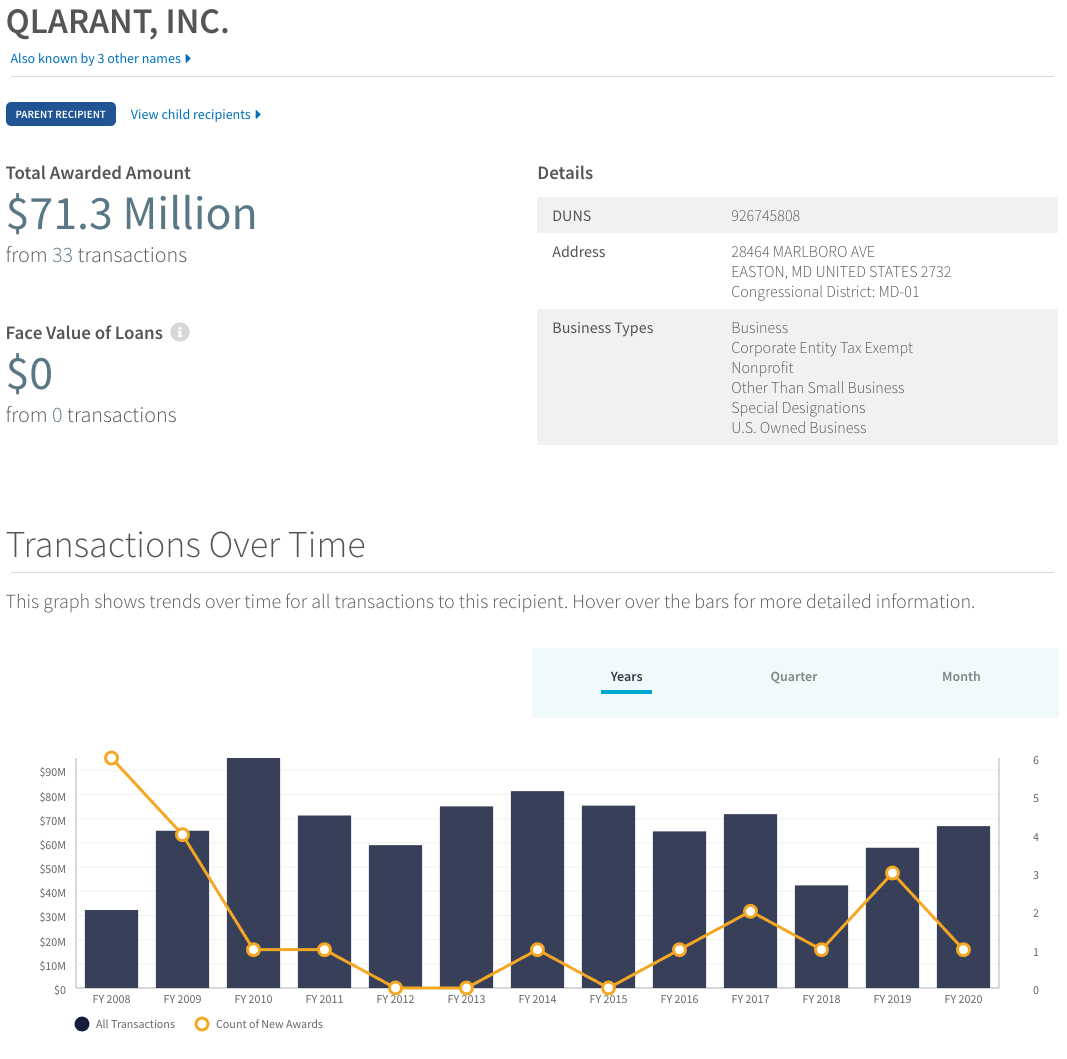

In subsequent blogs, I will explore more use of analytics to look at trends across GFY, marketshare analysis, contract vehicle patterns, contract awards, etc. Also, I will show you ways to use additional open source Python packages such as dask to process multiple GFY (@ ~10GB/GFY) on your local machine, dashboarding to share your analysis, and use of machine learning (ML) tools to look at patterns in the data including time series. I will also add additional open data sources so we can see how mashups of data can help us better understand the competitive landscape. 

Thank you and credit to [Ted Petrou](https://twitter.com/TedPetrou)  and his jupyter to medium.com tool. [See the how-to here](https://medium.com/dunder-data/jupyter-to-medium-initial-post-ecd140d339f0).